# Structural design of a 12-story reinforced concrete special moment frame building in Berkeley, CA - 3D Analysis

Notes:

- Following the ASCE 7-16 provisions for determining loads, and ACI 318-14 for concrete design.
- Most of the design follows the design example of the 2015 NEHRP Seismic Provisions
- Near fault sites: (with 15 km of an active fault capable of M7, or 10 km of an active fault capable of M6 - with exceptions in ASCE 7-16)
- Reinforced concrete frame members not designed as part of the seismic force-resisting system shall comply with Section 18.14 of ACI 318.

Design parameters:

- Location: Berkeley, CA
- Site class: C (very dense soil and soft rock)
- Risk Category: II
- Importance factor = 1.0
- Seismic response spectral parameters were obtained from the ATC hazard by location map (according to ASCE 7-16)

Structural modeling:
The following reduction factors were applied to the moment of interia of the model sections to account for cracking, presence of axial loads and loading duration effects (creep): 0.5 for columns, and 0.3 for beams.

In [1]:
# units
inch = 1.0;
kip = 1.0;
sec = 1.0;
ft = 12*inch;
lb = kip/1000;
ksi = 1.0;
psi = ksi/1000;
psf = ksi/1000/(12*12);
pcf = kip/1000/(12*12*12);

# normal weight concrete
rcdensity = 150*pcf;
lam = 1.0;
g = 386.1*inch/(sec**2)

In [2]:
# Building Geometric Parameters
import numpy as np

Nstory = 12;
Nbayx = 4;
Nbayy = 4;
Wbayx = 20*ft;
Wbayy = Wbayx;
Hcol1 = 18*ft;
Hcol = 13*ft;
Lbeam = Wbayx;

# Assume these dimensions for now
hbeam = 30*inch;
bbeam = 20*inch;
dcol = 30*inch;
bcol = dcol;

I_reduction_col = 0.5 # a little different than ACI 318 factors
I_reduction_beam = 0.3

Ncol = 25;
Nframe = 5; # Number of frames carrying the seismic weight per direction
Hbuilding = Hcol1 + Hcol*(Nstory - 1);

Lstory = np.empty(Nstory)
Lstory[0] = Hcol1
Lstory[1:] = Hcol

# material properties
## normal weight concrete
fc = 5*ksi
fy = 60*ksi
Est = 29000*ksi


# Slab thickness is determined using table 8.3.1.1 (ACI-318-14) - also check table 8.3.1.2
# for Steel grade 60
tmin = Lbeam/33; print('minimum slab thickness = ',round(tmin,1),' inches')
tslab = 8*inch;


minimum slab thickness =  7.3  inches


In [3]:
# Dimensional limits for beams of special moment frames
clear_span = Lbeam - dcol
if clear_span < 4*hbeam:
    print('INCREASE SPAN OR DECREASE BEAM DEPTH')
    
bbeam_min = min(0.3*hbeam,10)
if bbeam < bbeam_min:
    print('INCREASE BEAM WIDTH')

# If the width of the beam exceeds the width of the supporting column, check the requirements of ACI 318-14 section 18.6.2.1

# Dimensional limits for columns
if dcol < 12.0:
    print('INCREASE COLUMN DIMENSION')
if bcol < 12.0:
    print('INCREASE COLUMN DIMENSION')

## 1. Seismic Design Requirements

In [4]:
Ss = 2.154 # Short period MCE response spectral acceleration (USGS hazard tools
S1 = 0.83 # 1-sec period MCE response spectral acceleration
Fa = 1.2 # Short period site coefficient - ASCE7-16 Table 11.4-1
Fv = 1.4 # 1-sec period site coefficient - ASCE7-16 Table 11.4-1

print ('Response spectral acceleration parameters adjusted for site effects')
S_ms = Fa*Ss; print ('S_ms = ',S_ms)
S_m1 = Fv*S1; print ('S_m1 = ',S_m1)

print ('Design spectral acceleration parameters')
S_DS = round(2/3*S_ms,3); print ('S_DS = ',S_DS)
S_D1 = round(2/3*S_m1,3); print ('S_D1 = ',S_D1)

Response spectral acceleration parameters adjusted for site effects
S_ms =  2.5848
S_m1 =  1.162
Design spectral acceleration parameters
S_DS =  1.723
S_D1 =  0.775


T0 =  0.08996
TS =  0.4498


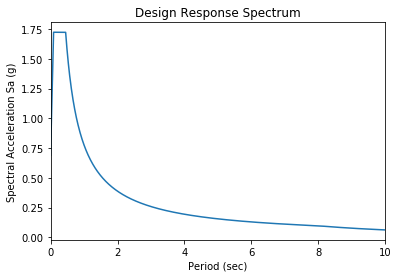

In [45]:
# create the response spectrum plot

import matplotlib.pyplot as plt

## determine period limits first
T0 = round(0.2*S_D1/S_DS,5); print('T0 = ',T0)
TS = round(S_D1/S_DS,5); print('TS = ',TS)
TL = 8 # Long period transition period (USGS hazard tools - ATC hazard map or ASCE7-16)

# design response spectrum
T = np.arange(0.,10.,0.01)
Sa = np.empty(len(T))

for i in range (0,len(T)):
    if T[i] < T0:
        Sa[i] = S_DS*(0.4 + 0.6*(T[i]/T0))
    elif T[i] >= T0 and T[i] < TS:
        Sa[i] = S_DS
    elif T[i] > TS and T[i] <= TL:
        Sa[i] = S_D1/T[i]
    else:
        Sa[i] = S_D1*TL/(T[i]**2)

plt.plot(T,Sa)
plt.xlim([0,10])
plt.xlabel('Period (sec)')
plt.ylabel('Spectral Acceleration Sa (g)')
plt.title('Design Response Spectrum');

In [6]:
# Determine seismic design category (section 11.6 - ASCE 7-16)
I = 1.0 # importance factor
# Risk Category II buildings with S1 >= 0.75 -> Seismic Design Category E

# Structural system design parameters (table 12.2-1 - ASCE 7-16)
# system: Special RC moment frame
# requirement sections: 12.2.5.5 and 14.2
R = 8 # response modification factor
omega = 3 # overstrength factor
Cd = 5.5 # deflection amplification factor

# Allowable interstory drift limit
delta_a = 0.02

# no torsional irregularity
# It is assumed (and will be verified later) that no soft/weak story irregularity exists.
# Assumed redunduncy factor
rho = 1.0

# write the scaled design response spectrum for MRSA
file1 = open(r'RS.txt','w+')
for i in range(0,len(T)):
    file1.write(str(round(T[i],2))+'     '+str(round(Sa[i]/(R/I),3))+'\n')
file1.close()

## 2. Determination of Seismic Forces

Assumptions:
- Because the building is symmetric in configuration, no horizontal irregularities of the types listed in table 12.3-1 exist; therefore, the building is modeled using a 2D representation
- For the purpose of determining the diaphragm flexibility, the span of the diahphragm should be considered as the distance between the lateral-load resisting elements. In this case, the span-to-depth ratio of the diagphram is 1.0; therefore, a rigid diaphragm assumption is permitted.


In [7]:
# Preliminary member sizing
# To determine preliminary sizes, analyze the building using approximate analysis methods under the appropriate
# combinations of dead, live and seismic loads
# This is actually not necessary, but I just like doing it the way Amit Kanvinde taught me for steel design

# Compute dead and live loads
perimeter = (Wbayx*Nbayx + Wbayy*Nbayy)*2;
Area = Nbayx*Wbayx * Nbayy*Wbayy;

## dead loads
DL_slab = tslab*rcdensity;

#compute cladding weight (which is actually on the perimeter only but will be distributed to floor)
clad_surf = 10*psf; # weight of vertical cladding
# assume the cladding is supported at all floors - assign tributary area loads
clad_load = clad_surf*Hcol*perimeter;
clad_load1 = clad_surf*(Hcol1 + Hcol)/2*perimeter; #first floor
clad_loadr = clad_surf*(Hcol/2)*perimeter; #roof

# Now distribute to floor area
clad = clad_load/Area
clad1 = clad_load1/Area
cladr = clad_loadr/Area

# Other superimposed dead loads
partition = 10*psf
roof = 10*psf
ceil = 10*psf

# Total distributed superimposed loads
DL_imp = clad + partition + ceil; # typical floor
DL_imp1 = clad1 + partition + ceil; # first floor
DL_impr = cladr + roof + ceil; #roof
print('Slab imposed dead loads in kip/inch^2 - typical floor = ',DL_imp)
print('Slab imposed dead loads in kip/inch^2 - first floor = ',DL_imp1)
print('Slab imposed dead loads in kip/inch^2 - roof floor = ',DL_impr)

# Total distributed dead loads
DL = DL_slab + DL_imp; # typical floor 
DL_1 = DL_slab + DL_imp1; # first floor
DL_r = DL_slab + DL_impr; #roof

# Beam self weight
DL_beamwt = hbeam*bbeam*rcdensity;

#Live loads
LL = 50*psf; # Office building occupancy level
LL_r = 20*psf; # roof
print('Slab live loads in kip/inch^2 - typical floor = ',LL)
print('Slab live loads in kip/inch^2 - roof floor = ',LL_r)

# Reduction is permitted for  live loads but will be ignored for now


Slab imposed dead loads in kip/inch^2 - typical floor =  0.0001840277777777778
Slab imposed dead loads in kip/inch^2 - first floor =  0.00019270833333333336
Slab imposed dead loads in kip/inch^2 - roof floor =  0.00016145833333333333
Slab live loads in kip/inch^2 - typical floor =  0.00034722222222222224
Slab live loads in kip/inch^2 - roof floor =  0.0001388888888888889


In [8]:
# Compute loads on typical frame beams
## A two-way slab is used, so triangular slab tributary areas on beams are appropropriate, but for simplicity,
## rectangular loads are used in liu of triangular slab loads

#######################################################################################
# INTERIOR OR EXTERIOR FRAME?
Ext_fac = 1.0; # for interior frame, Ext_fac = 1.0; for exterior frame, Ext_fac = 0.5;
#######################################################################################

# Beam dead loads
## "redistribute slab loads"
#beam_TA = Ext_fac*2*(Wbayx*Wbayy)/4; # tributary area for beam (note: only use this if creating 3D model)
beam_TA = Ext_fac*Wbayx*Wbayy; # tributary area for beam (note: only works if the slab is square)
DL_beam1 = DL_1*beam_TA/Lbeam; #beam distributed dead load at first floor (heavier than other floors)
DL_beam = DL*beam_TA/Lbeam; #beam distributed dead load at typical floor
DL_beamr = DL_r*beam_TA/Lbeam; #beam distributed dead load at roof level

print('For the analysis model:')
print('Total slab and superimposed DL on the first floor beam = ',DL_beam1,' kip/in')
print('Total slab and superimposed DL on a typical floor beam = ',DL_beam,' kip/in')
print('Total slab and superimposed DL on the roof beam = ',DL_beamr,' kip/in')

# total dead load on first floor beam (due to slab and self loads)
DL_beam1_tot = DL_beam1 + DL_beamwt;

# Beam live loads
LL_beam = LL*beam_TA/Lbeam; #beam distributed live load at first floor
LL_beamr = LL_r*beam_TA/Lbeam; #beam distributed live load at roof level
print('Total slab LL on a typical beam = ',LL_beam,' kip/in')
print('Total slab LL on the roof beam = ',LL_beamr,' kip/in')

print('For the manual analysis:')
print('Analyze a typical frame with the following distributed loads on the beams: ')
print('DL = ',DL_beam1_tot*12,' kips/ft')
print('LL = ',LL_beam*12,' kips/ft')

# Compute loads on columns
## use column tributary areas
col_TA = Ext_fac*Wbayx*Wbayy; # Tributary area for an interior column

DL_col = DL*col_TA; # DL for a typical column from a single floor
DL_col1 = DL_1*col_TA; # DL for the first floor column from a single floor
DL_colr = DL_r*col_TA; # DL for the roof column from the roof only

# self weight of beam on one column at one floor
DL_col_beamwt = DL_beamwt*Lbeam/2*2;

# Column self weight - distributed
DL_colwt = bcol*dcol*rcdensity;
#total self weight at first floor level
DL_colwt_tot = DL_colwt*Hbuilding;

# total DL on the first floor column
DL_col_tot = DL_col*(Nstory - 2) + DL_col1 + DL_colr + DL_colwt_tot + DL_col_beamwt*Nstory;

# live loads on column
LL_col = LL*col_TA; # DL for a typical column from a single floor
LL_colr = LL_r*col_TA; # DL for the roof column from the roof

# total LL on the first floor column
LL_col_tot = LL_col*(Nstory - 1) + LL_colr;

print('Axial loads on an interior first floor column: ')
print('DL = ',DL_col_tot,' kips')
print('LL = ',LL_col_tot,' kips')

For the analysis model:
Total slab and superimposed DL on the first floor beam =  0.21291666666666667  kip/in
Total slab and superimposed DL on a typical floor beam =  0.21083333333333337  kip/in
Total slab and superimposed DL on the roof beam =  0.2054166666666667  kip/in
Total slab LL on a typical beam =  0.08333333333333333  kip/in
Total slab LL on the roof beam =  0.03333333333333333  kip/in
For the manual analysis:
Analyze a typical frame with the following distributed loads on the beams: 
DL =  3.18  kips/ft
LL =  1.0  kips/ft
Axial loads on an interior first floor column: 
DL =  907.3375000000001  kips
LL =  228.0  kips


In [9]:
# Beam moments
# Note: getting the moments is easily programmable, but the whole point of preliminary sizing is to make sure you are able to
# do quick manual checks when needed, so chop chop
# In this case, we are assuming the beam inflection points are at 0.1 L from each joint (half way between fixed and simply
# supported)
print('Manual Analysis results:')
M_DL_pos_manual = 0.08*DL_beam1_tot*Lbeam**2; print('Beam maximum positive moment due to DL = ',M_DL_pos_manual/12, 'kip.ft')
M_DL_neg_manual = -0.045*DL_beam1_tot*Lbeam**2; print('Beam maximum negative moment due to DL = ',M_DL_neg_manual/12, 'kip.ft')

M_LL_pos_manual = 0.08*LL_beam*Lbeam**2; print('Beam maximum positive moment due to LL = ',M_LL_pos_manual/12, 'kip.ft')
M_LL_neg_manual = -0.045*LL_beam*Lbeam**2; print('Beam maximum negative moment due to LL = ',M_LL_neg_manual/12, 'kip.ft')


Manual Analysis results:
Beam maximum positive moment due to DL =  101.76 kip.ft
Beam maximum negative moment due to DL =  -57.24 kip.ft
Beam maximum positive moment due to LL =  32.0 kip.ft
Beam maximum negative moment due to LL =  -18.0 kip.ft


In [10]:
# SAP2000 model results - 2D analysis
# Note: the model has rigid offsets
# first floor beam

print('2D SAP model analysis results:')
M_DL_pos = 645.99; print('Beam maximum positive moment due to DL = ',M_DL_pos/12, 'kip.ft')
M_DL_neg = -829.16; print('Beam maximum negative moment due to DL = ',M_DL_neg/12, 'kip.ft')

M_LL_pos = 202.94; print('Beam maximum positive moment due to LL = ',M_LL_pos/12, 'kip.ft')
M_LL_neg = -260.61; print('Beam maximum negative moment due to LL = ',M_LL_neg/12, 'kip.ft')

# SAP2000 model results - 3D analysis
# Note: the model has rigid offsets
# first floor beam

print('3D SAP model analysis results:')
M_DL_pos = 416.2; print('Beam maximum positive moment due to DL = ',M_DL_pos/12, 'kip.ft')
M_DL_neg = -482.0; print('Beam maximum negative moment due to DL = ',M_DL_neg/12, 'kip.ft')

M_LL_pos = 127.9; print('Beam maximum positive moment due to LL = ',M_LL_pos/12, 'kip.ft')
M_LL_neg = -138.5; print('Beam maximum negative moment due to LL = ',M_LL_neg/12, 'kip.ft')

# Note that the analysis results from a 3d analysis are almost half those of the 2d analysis, which is to be expected because
# the beam tributary loads in the 2D analysis were doubled.

2D SAP model analysis results:
Beam maximum positive moment due to DL =  53.8325 kip.ft
Beam maximum negative moment due to DL =  -69.09666666666666 kip.ft
Beam maximum positive moment due to LL =  16.911666666666665 kip.ft
Beam maximum negative moment due to LL =  -21.7175 kip.ft
3D SAP model analysis results:
Beam maximum positive moment due to DL =  34.68333333333333 kip.ft
Beam maximum negative moment due to DL =  -40.166666666666664 kip.ft
Beam maximum positive moment due to LL =  10.658333333333333 kip.ft
Beam maximum negative moment due to LL =  -11.541666666666666 kip.ft


In [11]:
# compute building weight

# find the total length of all beams per floor
Lbeamx = (Nbayy + 1) * Wbayx * Nbayx;
Lbeamy = (Nbayx + 1) * Wbayy * Nbayy;

#############################################

# Compute total loads
Wslab = tslab*Area*rcdensity;

Wimp = DL_imp*Area;
Wimp1 = DL_imp1*Area;
Wimp_roof = DL_impr*Area;

Wbeams = (Lbeamx + Lbeamy)* bbeam * hbeam * rcdensity;

Wcols = Hcol*bcol*dcol*rcdensity*Ncol;
Wcols1 = (Hcol1 + Hcol)/2*bcol*dcol*rcdensity*Ncol;
Wcolsr = (Hcol/2)*bcol*dcol*rcdensity*Ncol;

# Floor weights
floorWt = Wslab + Wimp + Wbeams + Wcols; print('Typical floor weight = ',floorWt)
floorWt1 = Wslab + Wimp1 + Wbeams + Wcols1; print('First floor weight = ',floorWt1)
floorWtr = Wslab + Wimp_roof + Wbeams + Wcolsr; print('Roof weight = ',floorWtr)

W_seismic = floorWt*(Nstory - 2) + floorWt1 + floorWtr; print('Total seismic weight = ',W_seismic,'\n')

# Divide the seismic weight over the number of frames resisting the seismic load in each direction
print('Number of frames resisting the seismic force = ',Nframe)
W_frame_story = floorWt/Nframe; print('Typical floor weight on each frame = ',W_frame_story)
W_frame_story1 = floorWt1/Nframe; print('First floor weight on each frame = ',W_frame_story1)
W_frame_roof = floorWtr/Nframe; print('roof floor weight on each frame = ',W_frame_roof)
W_frame = W_seismic/Nframe;  print('Total seismic weight on each frame = ',W_frame,'\n')

# Compute floor and nodal masses for the analysis model
m_frame_story = W_frame_story/g; print('Typical floor mass per seismic frame = ',m_frame_story)
m_frame_story1 = W_frame_story1/g; print('First floor mass per seismic frame = ',m_frame_story1)
m_frame_roof = W_frame_roof/g; print('roof mass per seismic frame = ',m_frame_story,'\n')

Nnodes = Nbayx + 1;
m_node = m_frame_story/Nnodes; print('Typical floor nodal mass = ',m_node)
m_node1 = m_frame_story1/Nnodes; print('First floor nodal mass = ',m_node1)
m_noder = m_frame_roof/Nnodes; print('roof floor nodal mass = ',m_noder)



Typical floor weight =  1614.2875
First floor weight =  1680.88125
Roof weight =  1441.14375
Total seismic weight =  19264.899999999998 

Number of frames resisting the seismic force =  5
Typical floor weight on each frame =  322.85749999999996
First floor weight on each frame =  336.17625
roof floor weight on each frame =  288.22875
Total seismic weight on each frame =  3852.9799999999996 

Typical floor mass per seismic frame =  0.836201761201761
First floor mass per seismic frame =  0.870697358197358
roof mass per seismic frame =  0.836201761201761 

Typical floor nodal mass =  0.16724035224035222
First floor nodal mass =  0.1741394716394716
roof floor nodal mass =  0.1493026418026418


Estimate the building period

$T_{approx} = C_t h^x$

where $h$ is the structural height and $C_t$ and $x$ can be determined from table 12.8-2


In [12]:
# Estimate the building period

Ct = 0.016; # Table 12.8-2
x = 0.9; # Table 12.8-2

# Compute the coefficient for upper limit on calculated period
Cu_val = [1.7,1.6,1.5,1.4]
SD1_lim = [0.1,0.15,0.2,0.3]
slopes = np.empty(len(Cu_val)-1)

for i in range(0,len(Cu_val)-1):
    slopes[i] = (Cu_val[i+1] - Cu_val[i]) / (SD1_lim[i+1] - SD1_lim[i]);
    
if S_D1 <= SD1_lim[0]:
    Cu = Cu_val[0]
elif S_D1 <= SD1_lim[1]:
    Cu = Cu_val[0] + slopes[0]*(S_D1 - SD1_lim[0])
elif S_D1 <= SD1_lim[2]:
    Cu = Cu_val[1] + slopes[1]*(S_D1 - SD1_lim[1])
elif S_D1 <= SD1_lim[3]:
    Cu = Cu_val[2] + slopes[2]*(S_D1 - SD1_lim[2])
elif S_D1 > SD1_lim[3]:
    Cu = Cu_val[3]

print('The coefficient for upper limit on calculated period Cu = ',Cu)
    
height = ((Nstory - 1)*Hcol + Hcol1)/ft; #in feet

T_app = Ct*height**x; print('The approximate building period = ',T_app)
T_max = Cu*T_app; print('The maximum allowed building period for design = ', T_max)

The coefficient for upper limit on calculated period Cu =  1.4
The approximate building period =  1.549755802497669
The maximum allowed building period for design =  2.1696581234967365


In [13]:
# After running modal analysis using the SAP2000 model, the following period was obtained for the frame
T_model = 1.97;

# for the purpose of computing the seismic forces, T should not exceed T_max
if T_model > T_max:
    T1 = T_max
else:
    T1 = T_model
print('The building period for the purpose of computing the seimic forces = ',T1)

# Permitted analysis procedure
T_cond = 3.5*TS;

if T_model >= T_cond:
    print('Building period T > 3.5 Ts')
# because the building height > 160 ft and T > 3.5 Ts, ELF cannot be used as the analysis procedure for design, and Modal 
# Response Spectrum Analysis is required.

The building period for the purpose of computing the seimic forces =  1.97
Building period T > 3.5 Ts


Note: two different approaches for application of masses were used
1. The nodal masses computed here were distributed to floor nodes, all elements were assigned a zero-mass modifier,and the mass source was defined from the element masses and additional masses.
2. The mass source was defined from the dead load case with a factor = 1. This case includes all dead loads, inlcuding self weight of members

Both approaches result in very similar frame periods - it should be noted that the second approach cannot be used if not all frames are seismic load resisting frames; i.e. if the seismic mass inlcudes additional gravity frames

In [14]:
# calculation of the seismic response coefficient
Cs = S_DS/(R/I); # The ASCE guide states that this is applicable when T <= Ts

if T1<=TL:
    Cs_max = S_D1/(T1*R/I)
elif T1>TL:
    Cs_max = S_D1*TL/(T1**2*R/I)
    
Cs_min1 = max(0.044*S_DS*I,0.01)
    
if S1 >= 0.6:
    Cs_min2 = 0.5*S1/(R/I) # accounts for near-field effects
    
Cs_min3 = 0.01;
    
if Cs> Cs_max:
    Cs = Cs_max

if Cs < Cs_min1:
    Cs = Cs_min1
    
if Cs < Cs_min2:
    Cs = Cs_min2
    
if Cs < Cs_min3:
    Cs = Cs_min3

print('The seismic response coefficient Cs = ',round(Cs,5))
print('The seismic response coefficient for scaling drifts = ',round(Cs_min2,3))


The seismic response coefficient Cs =  0.07581
The seismic response coefficient for scaling drifts =  0.052


## 3. Equivalent Lateral Force Analysis

In [15]:
# ELF calculations
V = Cs*W_seismic; #get the base shear for the whole building (3D analysis)
print('Design base shear V = ',V)

# Vertical distribution of seismic forces

# compute the distribution factor k
perlim = [0.5,2.5];
klim = [1.0,2.0];

if T1 <= perlim[0]:
    k = klim[0];
elif T1 > perlim[0] and T1 < perlim[1]:
    slope = (klim[1]-klim[0])/(perlim[1] - perlim[0]);
    k = klim[0] + slope*(T1 - perlim[0]);
elif T1 >= 2.5:
    k = 2.0;
    
print('coefficient k = ',round(k,2))

# Compute the lateral forces
# Compute story heights
h_story = np.empty(Nstory)
h_story[0] = Hcol1

for n in range(1,Nstory):
    h_story[n] = h_story[n-1] + Hcol;
#print(h_story)

# Prepare all floor weights (for a single frame)
w_story = np.empty(Nstory)
for n in range(0,Nstory):
    if n == 0:
        w_story[n] = W_frame_story1
    elif n == Nstory-1:
        w_story[n] = W_frame_roof
    else:
        w_story[n] = W_frame_story

# Compute the sum wihi
sum_wihi = 0.0;
for n in range(0,Nstory):
    sum_wihi = sum_wihi + w_story[n]*h_story[n]
    
# compute load factors and loads
Cvx = np.empty(Nstory)
Fx = np.empty(Nstory)
Vx = np.empty(Nstory)
Mx = np.empty(Nstory)

print('ELF forces:')
for n in range(0,Nstory):
    Cvx[n] = w_story[n]*h_story[n]/sum_wihi
    Fx[n] = Cvx[n]*V # lateral force at each building level
    print('The lateral force at level ',n+1,' = ',round(Fx[n],2))
    

# compute the story shears and overturning moments
for n in range(0,Nstory):
    Vx[n] = sum(Fx[n:])
    Mx[n] = 0.0
    for i in range(n,Nstory):
        Mx[n] = Mx[n] + Fx[i]*(h_story[i] - h_story[n])
    #print(Mx[n])
print('Story shears in kips are: ',[round(i,2) for i in Vx])
    
Mx_base = 0.0;
for i in range(0,Nstory):
    Mx_base += Fx[i]*h_story[i]
print('Overturning moment = ',round(Mx_base/12,2),'kip.ft')


Design base shear V =  1460.5105988
coefficient k =  1.73
ELF forces:
The lateral force at level  1  =  25.89
The lateral force at level  2  =  42.82
The lateral force at level  3  =  60.77
The lateral force at level  4  =  78.72
The lateral force at level  5  =  96.68
The lateral force at level  6  =  114.63
The lateral force at level  7  =  132.59
The lateral force at level  8  =  150.54
The lateral force at level  9  =  168.5
The lateral force at level  10  =  186.45
The lateral force at level  11  =  204.41
The lateral force at level  12  =  198.51
Story shears in kips are:  [1460.51, 1434.62, 1391.81, 1331.04, 1252.32, 1155.64, 1041.0, 908.41, 757.87, 589.37, 402.92, 198.51]
Overturning moment =  162314.9 kip.ft


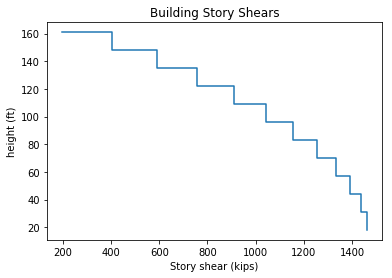

In [16]:
# Plot the story shears

plt.step(Vx,h_story/ft);
plt.xlabel('Story shear (kips)');
plt.ylabel('height (ft)');
plt.title('Building Story Shears');

In [17]:
# Compute moments due to lateral loads
## Using approximate portal frame analysis. Get out your pen and paper, mate

# Maximum beam moments at first floor due to seismic lateral loads
M_beam_E_manual = 561.9*kip*ft; # positive or negative, obviously

# Maximum interior column moments at first floor due to seismic lateral loads
M_col_E_manual = 657.0*kip*ft; # positive or negative, obviously

In [18]:
# Results of the SAP2000 analysis model - 2D analysis
# Note: the model has rigid member offsets

# Maximum beam moments at first floor due to seismic lateral loads
M_beam_E = 364.9*kip*ft; # positive or negative, obviously

# Maximum interior column moments at first floor due to seismic lateral loads
M_col_E = 715.3*kip*ft; # positive or negative, obviously

Basic strength design load combination

(1) $1.2 D + 1.6 L$

(2) $1.2 D + 0.5 L \pm 1.0 E$

(3) $0.9 D \pm 1.0 E$

Earthquake load effect

$E = \rho Q_E \pm 0.2 S_{DS} D$

The second and third load combinations become:

(2) $(1.2 + 0.2 S_{DS}) D + 0.5 L \pm Q_E$

(3) $(0.9 - 0.2 S_{DS}) D \pm Q_E$

No need for seismic load combinations with overstrength

In [19]:
# Preliminary Beam Design
def Ultimate_beam(beam,DL_pos,DL_neg,LL_pos,LL_neg,E):
    # This function determines the ultimate design load effects for beams
    # note that the positive DL and LL value is only used in load combo 1, because it occurs mid-span, and the negative DL
    # and LL values are used for the other load combos because they occur at the end (along with the seismic load maxima)
    Mu1 = 1.2*DL_pos + 1.6*LL_pos; # mid-span
    Mu2 = (1.2 + 0.2*S_DS)*DL_neg + 0.5*LL_neg + 1.0*E;
    Mu3 = (1.2 + 0.2*S_DS)*DL_neg + 0.5*LL_neg - 1.0*E;
    Mu4 = (0.9 - 0.2*S_DS)*DL_neg + 1.0*E;
    Mu5 = (0.9 - 0.2*S_DS)*DL_neg - 1.0*E;

    Mu_mid = Mu1; print('Utimate moment in mid span of beam',beam,' = ',Mu_mid/12,' kip.ft')
    Mu_end_max = max(Mu2,Mu3,Mu4,Mu5); print('Maximum ultimate moment at end of beam',beam,' = ',Mu_end_max/12,' kip.ft')
    Mu_end_min = min(Mu2,Mu3,Mu4,Mu5); print('Minimum ultimate moment at end of beam',beam,' = ',Mu_end_min/12,' kip.ft')
    return [Mu_mid,Mu_end_max,Mu_end_min];

Ultimate_beam(1,M_DL_pos,M_DL_neg,M_LL_pos,M_LL_neg,M_beam_E)

# just fyi
print('DL factor in combinations 2 and 3 = ',1.2 + 0.2*S_DS)
print('DL factor in combinations 4 and 5 = ',0.9 - 0.2*S_DS)

Utimate moment in mid span of beam 1  =  58.673333333333325  kip.ft
Maximum ultimate moment at end of beam 1  =  342.59143333333327  kip.ft
Minimum ultimate moment at end of beam 1  =  -432.7122666666666  kip.ft
DL factor in combinations 2 and 3 =  1.5446
DL factor in combinations 4 and 5 =  0.5554


## 4. Accidental Torsion Check

In [20]:
# Accidental torsion
# The building is symmetric so no torsional irregularity but accidental torsion needs to be considered
# Acciodental torsional moment at each floor is equal to the story force multiplied by 5% the story width perpendicular to
# the loading direction
tor = np.empty(Nstory);
arm = 0.05*Wbayx*Nbayx;
for i in range(0,Nstory):
    tor[i] = Fx[i]*arm

print('Accidental torsional moments in kip.ft [floors 1 through 12]:')
print(tor/12)
print('total torsional reaction should be ',sum(tor[:]))

Accidental torsional moments in kip.ft [floors 1 through 12]:
[103.54367955 171.2602738  243.0790983  314.89792279 386.71674729
 458.53557179 530.35439628 602.17322078 673.99204528 745.81086977
 817.62969427 794.04887529]
total torsional reaction should be  70104.50874240001


Accidental Torsion
- It is unlikely that the building has a torsional irregularity, but the standard requires that an accidental torsion check be performed using a 3D model with acceidental torsion (typically in a static analysis).
- Instead of applying the calculated torsional moments, the ELF forces are applied in the model with a 0.05 eccentricity.
- Since the building is symmetric, the check is performed in the x-direction only.
- The torsional amplification factor $A_x$ is 1.0 for checking accidental torsion.
- If no torsional irregularity exists, which is the case here, then the accidental torsion moments need not be included in the design.

Loading direction:
- for design category E: columns that are part of two intersecting seismic-force resisting systems, and are subjected to seismic axial force >= 20% of the axial design strength need to be designed for 100% of the seismic force in one direction + 30% of the force in the other direction. This will be checked later.

In [21]:
# Because the building is symmetric and the diaphragm is rigid, no twisting was observed in the model when the ELF forces
# were applied with no eccentricity

# Joint displacements at edges of the building (lateral ELF forces + accidental torsion)
disp1 = [0,0.494321,0.966106,1.432285,1.883094,2.310996,2.709401,3.071836,3.39195,3.663511,3.880666,4.038851,4.140045]
disp2 = [0,0.602176,1.177589,1.745587,2.29419,2.814257,3.297819,3.737046,4.124253,4.451884,4.712842,4.901603,5.02068]

#interstory drifts
drift1 = np.empty(Nstory)
drift2 = np.empty(Nstory)


for i in range(1,Nstory+1):
    drift1[i-1] = disp1[i] - disp1[i-1]
    drift2[i-1] = disp2[i] - disp2[i-1]

print('drifts at 1st edge = \n',drift1)
print('drifts at 2nd edge = \n',drift2)


# check for torsional irregularity
# ratio of maximum to average drifts
tor_ratio = np.empty(Nstory)
max_drift = np.empty(Nstory)
avg_drift = np.empty(Nstory)
for i in range(0,Nstory):
    avg_drift[i] = (drift1[i] + drift2[i])/2
    max_drift[i] = max(drift1[i],drift2[i])
    tor_ratio[i] = max_drift[i]/avg_drift[i]
    if tor_ratio[i] > 1.2 and tor_ratio[i] <= 1.4:
        print('TORSIONAL IRREGULARITY EXISTS')
    elif tor_ratio[i] > 1.4:
        print('EXTREME TORSIONAL IRREGULARITY EXISTS')

print('average drifts are = \n',avg_drift)
print('Ratios of maximum to average drifts are = \n',tor_ratio)



drifts at 1st edge = 
 [0.494321 0.471785 0.466179 0.450809 0.427902 0.398405 0.362435 0.320114
 0.271561 0.217155 0.158185 0.101194]
drifts at 2nd edge = 
 [0.602176 0.575413 0.567998 0.548603 0.520067 0.483562 0.439227 0.387207
 0.327631 0.260958 0.188761 0.119077]
average drifts are = 
 [0.5482485 0.523599  0.5170885 0.499706  0.4739845 0.4409835 0.400831
 0.3536605 0.299596  0.2390565 0.173473  0.1101355]
Ratios of maximum to average drifts are = 
 [1.09836324 1.09895741 1.09845413 1.09785154 1.09722364 1.0965535
 1.09579099 1.09485509 1.09357602 1.09161642 1.08812899 1.08118636]


## 5. Modal Response Spectrum Analysis

- MRSA was performed using the 3D model on SAP2000
- The number of modes required in ASCE 7-16 should be such that the combined modal mass is 100% of the structure's mass, or 90% in each orthognal direction
- In this case, all 12 modes were included in obtaining the response, which represents a little over 98% of the mass in each orthogonal direction
- The MRS analysis was applied in the x-direction only. However, for the purpose of finding the member design forces later, we will use 100% seismic loading in x direction plus 30% in y direction

In [22]:
# Scaling of the base shear and member forces
# section 12.9.1.4 of ASCE 7-16 requires scaling of MRSA forces if they are less than 100% of the calculated base shear
# using ELF procedure
V_mrsa = 855.155*kip; #base shear obtained from MRS
scalefac = V/V_mrsa;
print('The design member forces need to be scaled by ',round(scalefac,3))

# MRSA story shears (from SAP model)

Vx_mrsa = [855.168,818.826,771.853,726.917,682.459,635.756,587.354,534.118,472.433,398.894,300.021,162.329]

Vx_design = [round(scalefac*i,1) for i in Vx_mrsa]
print('The design story shears in kips are ',Vx_design)

# ratio of design shears (scaled MRSA) to ELF shears
shear_ratios = np.empty(len(Vx))
for i in range(0,len(Vx)):
    shear_ratios[i] = round(Vx_design[i]/Vx[i],2)
print('Just fyi, the ratios of the design story shear (scaled MRSA) to the story shears predicted by ELF are: \n',shear_ratios)


The design member forces need to be scaled by  1.708
The design story shears in kips are  [1460.5, 1398.5, 1318.2, 1241.5, 1165.6, 1085.8, 1003.1, 912.2, 806.9, 681.3, 512.4, 277.2]
Just fyi, the ratios of the design story shear (scaled MRSA) to the story shears predicted by ELF are: 
 [1.   0.97 0.95 0.93 0.93 0.94 0.96 1.   1.06 1.16 1.27 1.4 ]


## 6. Story Drift Checks

- One of the changes in ASCE 7-16 is scaling of the drifts taken from MRSA analysis if the base shear from MRSA is less than $C_s W$, where $C_s$ is:

$C_s = 0.5 \frac{S_1}{R/I_e}$ (which only applies for structures located where $S_1 > 0.6 g$)

- Based on that, the drifts here are scaled by $\frac{C_s W}{V_{MRSA}}$

The scale factor for drift checks is  1.1686380685372826
elastic drifts = 
 [0.317, 0.295, 0.282, 0.263, 0.243, 0.222, 0.2, 0.176, 0.15, 0.121, 0.089, 0.058]
inelastic drifts = 
 [1.741, 1.623, 1.549, 1.448, 1.338, 1.222, 1.099, 0.968, 0.825, 0.666, 0.491, 0.316]
design(scaled) drifts = 
 [2.035, 1.897, 1.811, 1.693, 1.564, 1.428, 1.285, 1.132, 0.964, 0.779, 0.574, 0.37]
Amplified drift ratios (by C_d) are 
 [0.806, 1.041, 0.993, 0.928, 0.858, 0.783, 0.705, 0.621, 0.529, 0.427, 0.315, 0.203]
The interstory drift ratios (after scaling, if needed) are: 
 [0.942, 1.217, 1.16, 1.084, 1.003, 0.915, 0.824, 0.726, 0.618, 0.499, 0.368, 0.237]
story 1 pass
story 2 pass
story 3 pass
story 4 pass
story 5 pass
story 6 pass
story 7 pass
story 8 pass
story 9 pass
story 10 pass
story 11 pass
story 12 pass
-------------------------------------------------------------------
inelastic drifts (ELF) = 
 [3.015, 2.88, 2.844, 2.748, 2.607, 2.428, 2.202, 1.945, 1.648, 1.315, 0.954, 0.606]


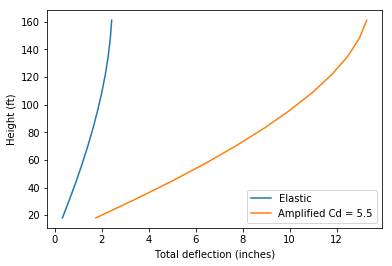

In [23]:
# Drift checks
#import xlrd

drift_scalefac = Cs_min2*W_seismic/V_mrsa
print('The scale factor for drift checks is ',drift_scalefac)
drift_limit = 2.0 #percent of the story height (table 12.12-1)

story_disp = [0,0.316626,0.611769,0.893471,1.156806,1.400071,1.622266,1.822174,1.998215,2.148197,2.269342,2.358644,2.41615]
# these are from the SAP MRSA analysis - in the future, can read them from Excel file directly

drift_e = np.empty(Nstory)

for i in range(1,len(story_disp)):
    drift_e[i-1] = story_disp[i] - story_disp[i-1]
print('elastic drifts = \n',[round(i,3) for i in drift_e])

# Design drifts
drift = [Cd/I*i for i in drift_e]
print('inelastic drifts = \n',[round(i,3) for i in drift])

scaled_drift = [i*drift_scalefac for i in drift]
print('design(scaled) drifts = \n',[round(i,3) for i in scaled_drift])

# now compute the drift ratios
drift_ratio = np.empty(len(drift))
for i in range(0,len(drift)):
    drift_ratio[i] = round(drift[i]/Lstory[i]*100,3)

print('Amplified drift ratios (by C_d) are \n',[round(i,3) for i in drift_ratio])
    
scaled_drift_ratio = [drift_scalefac*i for i in drift_ratio]
print('The interstory drift ratios (after scaling, if needed) are: \n',[round(i,3) for i in scaled_drift_ratio])

for i in range(0,len(drift)):
    if scaled_drift_ratio[i] <= drift_limit:
        print('story',i+1,'pass')
    else:
        print('story',i+1,'fail')

plt.plot(story_disp[1:],h_story/12);
plt.plot([Cd/I*i for i in story_disp[1:]],h_story/12);
plt.legend(['Elastic','Amplified Cd = 5.5']);
plt.xlabel('Total deflection (inches)');
plt.ylabel('Height (ft)');

print('-------------------------------------------------------------------')
# compute drifts for the ELF case (needed for P-Delta stability check)

story_disp_ELF = [0,0.5482,1.0718,1.5889,2.0886,2.5626,3.004,3.4044,3.7581,4.0577,4.2968,4.4702,4.5804]
# these are from the SAP ELF analysis - 3D model EQ case only

drift_e_ELF = np.empty(Nstory)

for i in range(1,len(story_disp_ELF)):
    drift_e_ELF[i-1] = story_disp_ELF[i] - story_disp_ELF[i-1]
#print('elastic drifts (ELF)= \n',drift_e_ELF)

# Design drifts
drift_ELF = [Cd/I*i for i in drift_e_ELF]
print('inelastic drifts (ELF) = \n',[round(i,3) for i in drift_ELF])


## 7. Soft Story Irregularity Check
- Having a soft-story irregularity will not impact the design because we are using MRSA for design anyway. Having an extreme soft-story irregularity is prohibited in Seismic Design Category E.
- Vertical structural irregularities types 1a, 1b or 2 (table 12.3-) do not apply when no story drift ratio under design lateral load is greater than 130% of the drift ratio of the next story above. The drift ratio between the top two stories is not required to be evaluated.

In [24]:
ratio_story_above = np.empty(Nstory - 2)
for i in range(0,Nstory-2):
    ratio_story_above[i] = drift_ratio[i]/drift_ratio[i+1]
    if ratio_story_above[i] > 1.3:
        print('A story stiffness check needs to be performed to check for vertical soft-story irregularity')
print('ratios between the interstory drift of each story to the story above (except last two): \n',\
      [round(i,3) for i in ratio_story_above])



A story stiffness check needs to be performed to check for vertical soft-story irregularity
ratios between the interstory drift of each story to the story above (except last two): 
 [0.774, 1.048, 1.07, 1.082, 1.096, 1.111, 1.135, 1.174, 1.239, 1.356]


- Note: even though the ratio at the 11th floor exceeds 1.3, a stiffness-check is not really needed because the presence of a 1a soft story irregularity will not impact the design (because we are already using MRSA). Based on the current value of of the ratio at 11th floor, it is highly unlikely that a 1b extreme soft-story irregularity exists.
- However, the stiffness check is performed anyway. This check was performed on SAP2000 by applying equal and opposite lateral forces to the top and bottom of each story, and determining the stiffness by dividing the force over the interstory drift.
- The soft-story irregularity check was performed for a 2D model and will not be repeated with a 3D model


In [25]:
# Story stiffness check
# story drifts from each individual analysis on SAP (NOT THE SAME ANALYSIS)
soft_check_dr = [0.2202 - 0.0925, 0.1985 - 0.085, 0.1947 - 0.0824, 0.1924 - 0.0804, 0.1905 - 0.0787, 0.1887 - 0.0771,\
                0.1871 - 0.0758, 0.1857 - 0.0745, 0.1839 - 0.073, 0.1805 - 0.0697, 0.1705 - 0.0591, 0.1462 - 0.0 ]
lateral_force = 100.0;
story_stiffness = [lateral_force/i for i in soft_check_dr]

story_stiffness_ratio = np.empty(len(story_stiffness)-1)
story_stiffness_ratio_avg = np.empty(len(story_stiffness)-3)
for i in range(0,len(story_stiffness)-1):
    story_stiffness_ratio[i] = story_stiffness[i]/story_stiffness[i+1]
    if story_stiffness_ratio[i] < 0.7 and story_stiffness_ratio[i] > 0.6:
        print('A soft story irregularity exists...')
    elif story_stiffness_ratio[i] < 0.6:
        print('OH NO an extreme soft story irregularity exists...')
    
for i in range(0,len(story_stiffness)-3):
    story_stiffness_ratio_avg[i] = story_stiffness[i]/((story_stiffness[i+1] + story_stiffness[i+2] + story_stiffness[i+3])/3)
    if story_stiffness_ratio_avg[i] < 0.8 and story_stiffness_ratio[i] > 0.7:
        print('A soft story irregularity exists...')
    elif story_stiffness_ratio[i] < 0.7:
        print('OH NO an extreme soft story irregularity exists...')
    
print('The ratios of each story stiffness to the story above: \n',[round(i,3) for i in story_stiffness_ratio])
print('The ratios of each story stiffness to the average of the three stories above: \n',\
      [round(i,3) for i in story_stiffness_ratio_avg])

The ratios of each story stiffness to the story above: 
 [0.889, 0.989, 0.997, 0.998, 0.998, 0.997, 0.999, 0.997, 0.999, 1.005, 1.312]
The ratios of each story stiffness to the average of the three stories above: 
 [0.882, 0.987, 0.996, 0.996, 0.996, 0.996, 0.997, 0.998, 1.089]


## 8. P-Delta Stability Check
- P-Delta effects need not be considered in the analysis if the stability coefficient for each floor is less than the maximum allowed stability coefficient.
- ASCE 7-16 requires that P-Delta stability check be performed using ELF forces

In [26]:
# maximum stability coefficient
theta_max1 = 0.1
theta_max2 = min(0.5/(1.*Cd),0.25)
theta_max = min(theta_max1,theta_max2)
print('The limit on the stability coefficient is :',round(theta_max,4))


DL_story = np.empty(Nstory)
#DL weight on each story
for i in range(0,Nstory):
    DL_story[i] = floorWt;
    if i == 0:
        DL_story[i] = floorWt1;
    elif i == Nstory-1:
        DL_story[i] = floorWtr;
        
print('The dead load on each story is: ',DL_story)
        
LL_story = np.empty(Nstory)
#LL weight on each story
for i in range(0,Nstory):
    LL_story[i] = LL*Area;
    if i == Nstory-1:
        LL_story[i] = LL_r*Area;
print('The live load on each story is: ',LL_story)

# compute the total axial load above each story
P_story = np.empty(Nstory)
theta_story = np.empty(Nstory)
for i in range(0,Nstory):
    P_story[i] = np.sum(DL_story[i:]) + np.sum(LL_story[i:])
print('The total unfactored axial load on each story in kips is \n',P_story)

########################################################################
    
for i in range(0,Nstory):
    theta_story[i] = P_story[i]*drift_ELF[i]*I/(Vx[i]*Lstory[i]*Cd)
    if theta_story[i] > theta_max:
        print('P-DELTA EFFECTS NEED TO BE CONSIDERED...')
    
print('The stability coefficient for each story is: \n',[round(i,3) for i in theta_story])

mag = [round(max(1/(1-i),1),3) for i in theta_story]

print('moment magnification for each story (IF NEEDED) is: \n',mag)

        

The limit on the stability coefficient is : 0.0909
The dead load on each story is:  [1680.88125 1614.2875  1614.2875  1614.2875  1614.2875  1614.2875
 1614.2875  1614.2875  1614.2875  1614.2875  1614.2875  1441.14375]
The live load on each story is:  [320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 320. 128.]
The total unfactored axial load on each story in kips is 
 [22912.9     20912.01875 18977.73125 17043.44375 15109.15625 13174.86875
 11240.58125  9306.29375  7372.00625  5437.71875  3503.43125  1569.14375]
The stability coefficient for each story is: 
 [0.04, 0.049, 0.045, 0.041, 0.037, 0.032, 0.028, 0.023, 0.019, 0.014, 0.01, 0.006]
moment magnification for each story (IF NEEDED) is: 
 [1.041, 1.051, 1.047, 1.043, 1.038, 1.033, 1.029, 1.024, 1.019, 1.014, 1.01, 1.006]


## 9. Structural Design of Frame Members
- Note: the MRSA output seismic forces are NOT the design forces. They need to be scaled by the scale factor scalefac first.
- In this case, this was worked into the model by creating load combinations with a scaled MRSA case by the scale factor (after the analysis)
- The model used for the design has 100% seismic force in x + 30% seismic force in y. The same model should probably be used for all other checks as well, but it does not matter that much.
- Beams are designed first, because the beam capacity affects the design of the column and beam-column joint
- Beam reinforcement is critical to ensure ductility (plastic hinging at the end of the beam)
- ACI 318 requires the beam width to be at least 75% of the column width to consider the beam-column joints confined.
- The design shears are based on the probable moment strength of the beam joint, as detailed in ACI 318 section 18.6.5
- The design shear strength of concrete must be taken as zero where axial force is small (less than 5% of the axial capacity) and where $V_E/V_u$ is larger than 0.5 ($V_E$ is the shear force due to the probable moment strength, and $V_u$ is the ultimate design shear at the joint including the shear due to the probable moment and factored gravity loads) - concrete design shear strength is assumed to be zero for all beams.

Other beam design requirements that need to be satisfied
- minimum two bars continous top and bottom
- positive moment strength greater than 50% negative moment strength at a joint
- minimum strength along member greater than 25% maximum strength

beam-column joint checks
- the joint shear demand is computed based on the probable moment strength of the beam.
- Here, the shear in the joint is computed as a function of the shear in the columm and tension/compression couple contributed by the beam moments
- refer to ACI 318 section 18.7.5.4 for the required amount of transverse reinforcement in the joint



In [27]:
# scaling factors
design_phi_conc = 0.9;
nominal_phi_conc = 1.0;
prob_phi_conc = 1.0;

design_phi_st = 1.0;
nominal_phi_st = 1.0;
prob_phi_st = 1.25;

### 9.1 Column Slenderness Analysis

- slenderness effects can be neglected if:

$\frac{k L}{r} <= 22$ for columns not braced against sidesway

$ \frac{k L}{r} <= 34 + 12(M_1/M_2)$ and $\frac{k l}{r} <= 40$ for columns braced against sidesway

where:

- k is the effective length factor, estimated from the Jackson and Moreland Alignment Charts (shown below)
- L is the column length
- r is the radius of gyration $ r = \sqrt{\frac{I_g}{A_g}}$ or approximated as 0.3 times the dimension in the direction stability is being considered for rectangular columns.
- $M_1/M_2$ is the ratio between the moments at the column ends; negative if the column is in single curvature and postitive for double curvature.
- columns are considered braced against sidesway when bracing elements have a total lateral stiffness of at least 12 times the gross stiffness of the columns within the story.


If slenderness cannot be neglected: design must include second order effects in one of the following ways:

- multiply first-order moments by a moment magnifier (ACI 318-14 provides different methods for non- and sway frames in section 6.6.4)
- elastic second-order analysis, or
- inelastic second order analysis.

Note: magnified second-order moments cannot exceed 1.4 first order moments.


Here I am using a P-Delta analysis in SAP2000 3D model, because it is the simplest method. Make sure to divide the column members along their length in the model to account for member curvature second order effects.

This frame is designated as a sway frame because no walls or other lateral bracing elements are present (although ACI 318 permits columns to be designed as part of a non-sway frame if the increase in column end moments due to second-order effects does not exceed 5% of first-order end moments)







<img src="Alignment Charts.jpg">

In the alignment charts, $\psi_A$ and $\psi_B$ represent the ratio $\sum EI/L_c$ the columns to $\sum EI/L_b$ of the beams at each end of the column. $L_b$ and $L_c$ are the beam and column spans measured center-line to center-line.

In [28]:
##################################################################################################
############################# RELATIVE STIFFNESS RATIO CALCULATOR #########################################
##################################################################################################
# this function is related to finding the relative stiffness ratios used for evaluating column slenderness. The function
# is NOT used in the design process (the slenderness check is done manually because it has a lot of nuances). However, 
# you can use this function as a calculator of the stiffness factors for each column individually to aid the calculations.

# IT IS ASSUMED THAT THE MODULUS OF ELASTICITY E IS THE SAME FOR BEAMS AND COLUMNS
def stiffness_ratios(col_group,intorext,btm_bound,top_bound,bcol,dcol,Lcol,bcol_top,dcol_top,Lcol_top,\
                     bcol_btm,dcol_btm,Lcol_btm,bbeam,hbeam,Lbeam,I_reduction_col,I_reduction_beam):
    # col_group: group number of the column considered
    # intorext: whether the column considered is interior or exterior. options are 'int' and 'ext'
    # btm_bound: the bottm bounday condition - options are 'fixed' or 'beam' (i.e. connected to a beam)
    # top_bound: the bottm bounday condition - options are 'fixed' or 'beam' (i.e. connected to a beam)
    # bcol,dcol,Lcol: dimensions of the column under consideration
    # bcol_top,dcol_top,Lcol_top: dimensions of the column connecting at the top end
    # bcol_btm,dcol_btm,Lcol_btm: dimensions of the column connecting at the bottom end (if fixed, the value does not matter)
    # bbeam,dbeam,Lbeam: dimensions of the connecting beam(s)
    # I_reduction_col,I_reduction_beam: reduction factors for the moment of interia of beams and columns (already established)

    Icol = I_reduction_col*bcol*dcol**3/12
    Icol_top = I_reduction_col*bcol_top*dcol_top**3/12
    Icol_btm = I_reduction_col*bcol_btm*dcol_btm**3/12
    Ibeam = I_reduction_beam*bbeam*hbeam**3/12

    if intorext == 'int':
        nbeams = 2
    elif intorext == 'ext':
        nbeams = 1

    if btm_bound == 'fixed':
        psi_btm = 1.0
    else:
         psi_btm = (Icol_btm/Lcol_btm + Icol/Lcol)/(nbeams*Ibeam/Lbeam);

    if top_bound == 'fixed':
        psi_top = 1.0
    else:
         psi_top = (Icol_top/Lcol_top + Icol/Lcol)/(nbeams*Ibeam/Lbeam);
    
    print('The columns/beam stiffness ratios (psi) for column ',col_group,' top and bottom are ',round(psi_top,2)\
          ,' and ',round(psi_btm,2))
    print('Look up the effective length factor k in the alignment charts...')
    
# for example: first floor exterior column
bcol_top = bcol
dcol_top = dcol
Hcol_top = Hcol
bcol_btm = 0; # fixed
dcol_btm = 0
Hcol_btm = 0
stiffness_ratios(1,'ext','fixed','beam',bcol,dcol,Hcol1,bcol_top,dcol_top,Hcol_top,\
                     bcol_btm,dcol_btm,Hcol_btm,bbeam,hbeam,Lbeam,I_reduction_col,I_reduction_beam)

The columns/beam stiffness ratios (psi) for column  1  top and bottom are  6.62  and  1.0
Look up the effective length factor k in the alignment charts...


### 9.2 Member forces

#### 9.2.1 Column design actions

In [29]:
# The structural members are grouped into three different designs for beams, and three different designs for columns

floor_assign = [1,5,9] # starting floors of each column and beam group

#Column groups
col_groups = [1,2,3]
Pu_D_L = [1613.3,1061.1,519.0]
Pu_D_L_E = [1726.4,1115.2,553.3]
Pu_D_E = [581.0,389.1,196.4] #no uplift!

# first order moments
Mu_D_L_E_lin = [7880.1,4272.7,3288.0]# not used because the column design is based on the beam nominal moment capacity
Mu_D_E_lin = [7872.2,4086.7,3016.8]

# second order moments (based on P-delta analysis on SAP2000)
Mu_D_L_E = [8140.5,4410.3,3291.7]# not going to be used because the column design is based on the beam nominal moment capacity
Mu_D_E = [8132.9,4234.1,3044.1]

ratio1 = np.empty(len(col_groups))
ratio2 = np.empty(len(col_groups))
# check that second order moments are not more than 1.4 first order moments
for i in range(0,len(col_groups)):
    ratio1[i] = Mu_D_L_E[i]/Mu_D_L_E_lin[i]
    if ratio1[i] > 1.4:
        print("Unacceptably high P-Delta effect - REDESIGN COLUMNS OF GROUP ",i)
        
    ratio2[i] = Mu_D_E[i]/Mu_D_E_lin[i]
    if ratio2[i] > 1.4:
        print("Unacceptably high P-Delta effect - REDESIGN COLUMNS OF GROUP ",i)
    
# Column design actions
print('COLUMN DESIGN ACTIONS:\n')
Pu_max = np.empty(len(col_groups))
Pu_min = np.empty(len(col_groups))

for i in range(0,len(col_groups)):
    Pu_max[i] = max(Pu_D_L[i],Pu_D_L_E[i],Pu_D_E[i])
    Pu_min[i] = min(Pu_D_L[i],Pu_D_L_E[i],Pu_D_E[i])

print('the maximum factored axial load on each column group is',Pu_max)
print('the minimum factored axial load on each column group is',Pu_min)

# get the column design moments
print("""Note: COLUMN MOMENTS ARE BASED ON SECOND ORDER ANALYSIS ARE USED BECAUSE THE ANALYSIS SHOWED THAT
SLENDERNESS EFFECTS MUST BE CONSIDERED - MEANING THAT SECOND ORDER MOMENTS NEED TO BE INCLUDED""")
Mu_col = np.empty(len(col_groups))
mag_Mu_col = np.empty(len(col_groups))

for i in range(0,len(col_groups)):
    Mu_col[i] = max(Mu_D_L_E[i],Mu_D_E[i])
 #   mag_Mu_col[i] = Mu_col[i]*mag[floor_assign[i]-1]
    mag_Mu_col[i] = Mu_col[i] # this is the value used for the rest of the design process - since P-Delta effects are
    # accounted for using second order analysis, no magnification is needed - magnify if using first order analysis

print('Second order (or magnified) column moments are:',mag_Mu_col)
print("""the required moment capacity of the column is taken to be the maximum of the strong column-weak beam 
asumption moments, and second-order moments from factored loads \n""")

print("ratio of second to first order column moments are (D + L + E):",[round(i,3) for i in ratio1])
print("ratio of second to first order column moments are (D + E):",[round(i,3) for i in ratio2])

COLUMN DESIGN ACTIONS:

the maximum factored axial load on each column group is [1726.4 1115.2  553.3]
the minimum factored axial load on each column group is [581.  389.1 196.4]
Note: COLUMN MOMENTS ARE BASED ON SECOND ORDER ANALYSIS ARE USED BECAUSE THE ANALYSIS SHOWED THAT
SLENDERNESS EFFECTS MUST BE CONSIDERED - MEANING THAT SECOND ORDER MOMENTS NEED TO BE INCLUDED
Second order (or magnified) column moments are: [8140.5 4410.3 3291.7]
the required moment capacity of the column is taken to be the maximum of the strong column-weak beam 
asumption moments, and second-order moments from factored loads 

ratio of second to first order column moments are (D + L + E): [1.033, 1.032, 1.001]
ratio of second to first order column moments are (D + E): [1.033, 1.036, 1.009]


#### 9.2.2 Beam design actions

In [30]:
#Beam groups
beam_groups = [1,2,3]

# first order moments:
# Mid-span maxima
Mu_D_L_mid = [704.0,676.8,670.9]
Mu_D_L_E_mid_lin = [855.5,770.4,730.1]

# end-span maxima
Mu_D_L_E_end_pos_lin = [2874.3,2293.6,1441.3]
Mu_D_L_E_end_neg_lin = [-4147.4,-3693.7,-2886.3]
Mu_D_E_end_pos_lin = [3254.4,2496.0,1573.0]
Mu_D_E_end_neg_lin = [-3637.0,-2918.2,-2008.1]

#shears
V_G_design_lin = [27.1,28.7,29.7] # shear due to factored gravity load (with the seismic combo factors - (load combo 2))

#########################################################################################################
# second order moments:
# Mid-span maxima
Mu_D_L_E_mid = [865.3,785.2,746.7]

# end-span maxima
Mu_D_L_E_end_pos = [3050.2,2374.5,1443.9]
Mu_D_L_E_end_neg = [-4317.5,-3800.0,-2928.0]
Mu_D_E_end_pos = [3430.0,2620.6,1575.6]
Mu_D_E_end_neg = [-3812.2,-3000.9,-2039.1]

#shears
V_G_design = [27.5,29.5,30.6] # shear due to factored gravity load (with the seismic combo factors - (load combo 2))

print('BEAM DESIGN ACTIONS:\n')
#Beam design moments and shears
Mu_mid = np.empty(len(beam_groups))
Mu_end_pos = np.empty(len(beam_groups))
Mu_end_neg = np.empty(len(beam_groups))
Vu = np.empty(len(beam_groups))

for i in range(0,len(beam_groups)):
    Mu_mid[i] = max(Mu_D_L_mid[i],Mu_D_L_E_mid[i])
    Mu_end_neg[i] = min(Mu_D_L_E_end_neg[i],Mu_D_E_end_neg[i])
    Mu_end_pos[i] = max(Mu_D_L_E_end_pos[i],Mu_D_E_end_pos[i])
    #Vu[i] = max(Vu_D_L_E[i],Vu_D_E[i])
    
#print('The design mid-span moments are: ',Mu_mid)
print('The design end-span negative moments are: ',Mu_end_neg)
print('The design end-span positive moments are: ',Mu_end_pos)
#print('The design shears are: ',Vu)


BEAM DESIGN ACTIONS:

The design end-span negative moments are:  [-4317.5 -3800.  -2928. ]
The design end-span positive moments are:  [3430.  2620.6 1575.6]


### 9.3 Beam Design Functions

#### 9.3.1 Compute beam effective depth

In [31]:
def effective_depth(h,ccover,phi_t,phi_l):
    # Because the beams are spanning two orthogonal directions, the effective depth is different for each direction
    d_EW = h - ccover - phi_t - phi_l/2;
    d_NS = h - ccover - phi_t - phi_l - phi_l/2;
    d = d_NS # conservatively
    return d
    # if you change this assumption here, it will change everywhere!

#### 9.3.2 Compute T-beam effective width

In [32]:
def T_beam_flange(int_or_ext,bbeam,Lbeam,tslab):
    if int_or_ext == 'int':
        # Effective T-beam width for positive moment (ACI 318 6.3.2)
        # interior
        b_tbeam_int1 = 8*tslab;
        clear_span = Lbeam - bbeam
        b_tbeam_int2 = clear_span/2; # modify this for non-symmetric geometry
        b_tbeam_int3 = clear_span/8;
        b_tbeam_int = min(b_tbeam_int1,b_tbeam_int2,b_tbeam_int3)

        bf = bbeam + 2*b_tbeam_int; # Effective T-beam width for positive moment for an interior beam
    elif int_or_ext == 'ext':
        # exterior (one side of web)
        b_tbeam_ext1 = 6*tslab;
        b_tbeam_ext2 = clear_span/2; # modify this for non-symmetric geometry
        b_tbeam_ext3 = clear_span/12;
        b_tbeam_ext = min(b_tbeam_ext1,b_tbeam_ext2,b_tbeam_ext3)

        bf = bbeam + b_tbeam_ext; # Effective T-beam width for positive moment for an extrerior beam
    return bf

#### 9.3.3 Compute the nominal capacity of a beam section

In [33]:
# FLEXURAL REINFORCEMENT FUNCTION
import math
def beam_Mn(beam,Mu,nbar,phi_l,phi_t,b,h,ccover):
    # compute the nominal strength of a beam
    d = effective_depth(h,ccover,phi_t,phi_l)
    Abar_l = math.pi*phi_l**2/4
    As = nbar*Abar_l;
    # depth of compression block
    a = As*fy/(0.85*fc*b)
    #nominal strength
    Mn = As*fy*(d - a/2)
    
    return Mn

#### 9.3.4 Design beam flexural reinforcement

In [34]:
# FLEXURAL REINFORCEMENT FUNCTION
import math
def beam_reinf(beam,Mu,nbar,phi_l,phi_t,b,h,ccover,bbeam):
    # compute the nominal, design and probable strength of a beam
    # for positive moments, the beam will be designed as  a T-beam -> width of beam will include the allowed slab flage width
    # the probable strength will include the slab reinforcement outside the beam width
    # the slab is assumed to be reinforced with minimum reinforcement = 0.002
    
    d = effective_depth(h,ccover,phi_t,phi_l)
    Abar_l = math.pi*phi_l**2/4;
    As = nbar*Abar_l;
    
    # Minimum rft in any beam section (ACI 318 18.6.3.1)
    As_min1 = 3*math.sqrt(fc*1000)*bbeam*d/(fy*1000); # the stresses have to be in psi
    As_min2 = 200*bbeam*d/(fy*1000)
    As_min = max(As_min1,As_min2)

    if As < As_min:
        print('INCREASE REINFORCEMENT TO SATISFY MINIMUM REQUIRED')
    if As/(b*d) > 0.025:
        print('THE REINFORCEMENT RATIO EXCEEDS THE MAXIMUM - REDESIGN MEMBER')
    # depth of compression block
    a = As*fy/(0.85*fc*b)
    #nominal strength
    Mn = As*fy*(d - a/2)
    # design strength
    M_design = design_phi_conc*Mn

    #probable strength
    # slab reinforcement
    As_slab = 0.002*tslab*(b-bbeam)
    As_prob = As + As_slab;
    # depth of compression block
    a_prob = As_prob*1.25*fy/(0.85*fc*b)
    #probable strength
    M_prob = As_prob*1.25*fy*(d - a_prob/2)
 
    print('Ratio of design moment over ultimate moment for beam',beam,'=',round(M_design/abs(Mu),3))
    print('design strength = ',round(M_design,1))
    print('probable strength = ',round(M_prob,1))
    if M_design > abs(Mu):
        print('OKAY \n')
    else:
        print('REDESIGN \n')
    
    # check development length requirements (may control the dimensions of exterior columns)
    ldh = (fy*1000*phi_l)/(65*lam*math.sqrt(fc*1000)) # development length for hooked bars
    ldh_min1 = 6
    ldh_min2 = 8*phi_l

    ldh_min = max(ldh_min1,ldh_min2)
    if ldh < ldh_min:
        ldh = ldh_min

    # development lengths for different bars
    ld_typ = 2.5*ldh; #straight typical bars
    ld_top = 3.25*ldh; # straight top bars

    #print('required development length for hooked bars = ',ldh)
    #print('required development length for straight typical bars = ',ld_typ)
    #print('required development length for straight top bars = ',ld_top)

    # column sizing note
    # a minimum ratio of 20 is required between the column width and diameter of largest lonitudinal beam bar passing
    # through the joint
    bcol_min = 20*phi_l
    print('Note: The column dimension cannot be less than ',bcol_min,'\n')

    return M_prob

#### 9.3.5 Shear design of a beam section

In [35]:
# SHEAR DESIGN
def shear_design(V_design,nlegs,dbar_t,d,dbar_pos,dbar_neg,trans_spacing):
    Av = nlegs*math.pi*dbar_t**2/4;
    s_beam = 0.75*Av*fy*d/V_design;
    s_max1 = d/4
    s_max2 = 6*dbar_pos
    s_max3 = 6*dbar_neg
    
    s_max_end = min(s_max1,s_max2,s_max3) # maximum spacing at the beam end region
    s_max_all = d/2 # maximum spacing outside the beam end region
    
    if s_beam >s_max_all:
        s_beam = s_max_all
        
    print('maximum allowed spacing og transverse reinforcement along the beam is',round(s_beam,1))
    
    if trans_spacing <= s_beam:
        print('SUPPLIED TRANSVERSE REINFORCEMENT IS ADEQUATE')
        
    print('Maximum transverse reinforcement spacing at the beam ends = ',s_max_end,'\n')
    return s_max_end

#### 9.3.6 Check the beam-column joint capacity

In [36]:
# BEAM-COLUMN JOINT CHECK
def joint_check(M_prob_neg,M_prob_pos,V_E_design,bcol,dcol,Hcol,dbar_neg,nbar_neg,dbar_pos,nbar_pos):
    # internal joint
    # shear in the column
    V_col = (M_prob_neg + M_prob_pos + 2*V_E_design*dcol/2)/Hcol #note that shear due to gravity loads is not included because
    # it is insignificant (except at the end columns where the seismic shear is much less)
    # probable forces in the negative moment rft
    Abar_neg = math.pi*dbar_neg**2/4
    f_bar_neg = nbar_neg*Abar_neg*1.25*fy
    # probable forces in the positive moment rft
    Abar_pos = math.pi*dbar_pos**2/4
    f_bar_pos = nbar_pos*Abar_pos*1.25*fy
    # joint shear demand
    V_joint = f_bar_neg + f_bar_pos - V_col
    
    # compute nominal shear strength
    ## effective joint area
    h_joint = dcol;
    if bbeam >= bcol:
        w_joint = bcol
    else:
        w_joint_max1 = bbeam + h_joint
        w_joint_max2 = bcol # assuming that the longitudinal axes of the beam and column are on the same plane (i.e., the beam
        # is centered on the column)
        w_joint = min(w_joint_max1,w_joint_max2)
    A_joint = h_joint*w_joint;
    # joint shear strength
    if bbeam  < 0.75*bcol:
        print('joint is not confined')
        Vn_joint = 12*lam*math.sqrt(fc*1000)*A_joint/1000
    else:
        print('it is assumed that joint is confined on three faces or two opposite faces')
        Vn_joint = 15*lam*math.sqrt(fc*1000)*A_joint/1000
    
    V_design_joint = 0.85*Vn_joint
    print('ratio of joint probable capacity to demand =',round(V_design_joint/V_joint,2))
    if V_design_joint > V_joint:
        print('JOINT OKAY')
    else:
        print('REDESIGN JOINT')

#### 9.3.7 Overall beam design function (flexural, shear, joint check)

In [37]:
# BEAM DESIGN FUNCTION
def beam_design(beam,int_or_ext,Mu_pos,Mu_neg,V_G,nbar_pos,nbar_neg,dbar_pos,dbar_neg,bbeam,h,nlegs,dbar_t,ccover,\
               trans_spacing):
    
    print('DESIGN FOR BEAM',beam)
    print('1. FLEXURAL DESIGN')
    
    # design the beam top and bottom reinforcement, and shear reinforcement
    print('reinforcement design for end-negative moments')
    # beam widths and depths
    M_prob_neg = beam_reinf(beam,Mu_neg,nbar_neg,dbar_neg,dbar_t,bbeam,h,ccover,bbeam)
    print('reinforcement design for end-positive moments')
    bf = T_beam_flange(int_or_ext,bbeam,Lbeam,tslab)
    M_prob_pos = beam_reinf(beam,Mu_pos,nbar_pos,dbar_pos,dbar_t,bf,h,ccover,bbeam)
    
    print('2. SHEAR DESIGN')
    d = effective_depth(h,ccover,dbar_t,dbar_neg) # use d based on the size of the negative rft bars
    clear_span = Lbeam - dcol;
    V_E_design = (M_prob_neg + M_prob_pos)/clear_span
    
    V_design_end1 = V_E_design + V_G
    V_design_end2  = V_E_design - V_G
    V_design = max(abs(V_design_end1),abs(V_design_end2))
    print('The design shear for beam ',beam,'= ',round(V_design,1))
    # Note: here we will not care about shear design mid-span because we will use the same spacing throughout the beam
    s_max_end = shear_design(V_design,nlegs,dbar_t,d,dbar_pos,dbar_neg,trans_spacing)
    
    print('3. BEAM-COLUMN JOINT CHECK')
    joint_check(M_prob_neg,M_prob_pos,V_E_design,bcol,dcol,Hcol,dbar_neg,nbar_neg,dbar_pos,nbar_pos)
    print('------------------------------------------------------------------------------------------------------')
    return M_prob_neg,M_prob_pos,s_max_end

### 9.4. Column design functions

#### 9.4.1. Column interaction diagram

In [38]:
def interact_diagram(col,d_vec,As_vec,bcol,dcol,col_Mn_req,Pu_max,Pu_min):
    # assumed parameters
    epsu = 0.003;
    ety = 0.002;
    beta1 = 0.85;
    fy_pr = 1.25*fy;

    ## 1. Find the depth of the neutral axis c by solving the force equilibrium equation graphically

    # loop through different values of NA depths
    x = np.arange(dcol/30,1.4*dcol,dcol/200)

    Pn = np.empty(len(x))
    Mn = np.empty(len(x))
    P_design = np.empty(len(x))
    M_design_col = np.empty(len(x))
    P_pr = np.empty(len(x))
    M_pr = np.empty(len(x))
    design_phi = np.empty(len(x))
    epss = np.empty(len(d_vec))
    fs = np.empty(len(d_vec))
    fs_pr = np.empty(len(d_vec))

    # loop over all values of c
    for i in range(0,len(x)):
        # loop over all rows of steel and compute strains and stresses for given c
        for k in range (0,len(d_vec)):
            epss[k] = (x[i] - d_vec[k])/x[i]*epsu
            fs[k] = epss[k]*Est
            fs_pr[k] = epss[k]*Est
            if abs(fs[k]) > fy:
                fs[k] = fy*np.sign(fs[k]);
            if abs(fs_pr[k]) > fy_pr:
                fs_pr[k] = fy_pr*np.sign(fs_pr[k]);
        #print(epss)
        # compute equilibrium function
        Pn[i] = 0.85*fc*beta1*x[i]*bcol + As_vec[0]*fs[0] + As_vec[1]*fs[1] +\
            As_vec[2]*fs[2] + As_vec[3]*fs[3]

        # calculate the nominal moment capacity (take moments about the centroid)
        Mn[i] = 0.85*fc*beta1*x[i]*bcol*(dcol/2 - (beta1*x[i])/2) + As_vec[0]*fs[0]*(dcol/2 - d_vec[0])\
            + As_vec[1]*fs[1]*(dcol/2 - d_vec[1]) + As_vec[2]*fs[2]*(dcol/2 - d_vec[2])\
            + As_vec[3]*fs[3]*(dcol/2 - d_vec[3])
        
        # calculate the probable axial and moment strength
        P_pr[i] = 0.85*fc*beta1*x[i]*bcol + As_vec[0]*fs_pr[0] + As_vec[1]*fs_pr[1] +\
            As_vec[2]*fs_pr[2] + As_vec[3]*fs_pr[3]
        
        M_pr[i] = 0.85*fc*beta1*x[i]*bcol*(dcol/2 - (beta1*x[i])/2) + As_vec[0]*fs_pr[0]*(dcol/2 - d_vec[0])\
            + As_vec[1]*fs_pr[1]*(dcol/2 - d_vec[1]) + As_vec[2]*fs_pr[2]*(dcol/2 - d_vec[2])\
            + As_vec[3]*fs_pr[3]*(dcol/2 - d_vec[3])
        
        # check the tensile strain in the tension rft to determine if the section is: 1. compression-controlled, 2. transition,
        # or 3. tension controlled
        if abs(epss[-1]) <= ety:
            design_phi[i] = 0.65
        elif abs(epss[-1]) > ety and abs(epss[-1]) < 0.005:
            design_phi[i] = 0.65 + 0.25*(abs(epss[-1]) - ety)/(0.005 - ety)
        elif abs(epss[-1]) >= 0.005:
            design_phi[i] = 0.9

        P_design[i] = Pn[i]*design_phi[i]
        M_design_col[i] = Mn[i]*design_phi[i]

    ################################################################################
    # compute the case of pure compression (to determine maximum allowed axial load)
    # subject to compression only -> compression controlled -> phi = 0.65
    P_max = 0.65*0.85*fc*(dcol*bcol - np.sum(As_vec)) + fy*np.sum(As_vec)
    P_max_allowable = 0.8*P_max # from Table 22.4.2.1 in ACI 318-14

    # plot the column interaction diagram
    xlimit = 1.1*max(Mn)
    plt.figure();
    plt.plot(Mn,Pn);
    plt.xlim([0,xlimit]);
    plt.xlabel('Mn (kip.in)');
    plt.ylabel('Pn (kips)');
    plt.title('Column '+str(col)+' Interaction Diagram');

    plt.plot(M_design_col,P_design);
    plt.plot(M_pr,P_pr);

    # check adequacy of column
    M_design_value1 = np.interp(Pu_max,P_design,M_design_col)
    M_design_value2 = np.interp(Pu_min,P_design,M_design_col)
    if col_Mn_req < M_design_value1:
        if col_Mn_req < M_design_value2:
            if Pu_max <= P_max_allowable:
                print('COLUMN ',col,' IS ADEQUATE AGAINST AXIAL FORCE AND BENDING MOMENT')
            else:
                print('REDESIGN COLUMN',col)
        else:
            print('REDESIGN COLUMN',col)
    else:
        print('REDESIGN COLUMN',col)

    plt.scatter(col_Mn_req,Pu_max)
    plt.scatter(col_Mn_req,Pu_min)
    
    M_pr1 = np.interp(Pu_max,P_pr,M_pr)
    M_pr2 = np.interp(Pu_min,P_pr,M_pr)
    M_pr_col = max(M_pr1,M_pr2)
    print('The maximum probable moment of the column is',round(M_pr_col,0),'\n')
    
    if M_pr1 > M_pr2:
        plt.scatter(M_pr_col,Pu_max)
    else:
        plt.scatter(M_pr_col,Pu_min)
        
    plt.legend(['Nominal Strength','Design Strength','Probable Strength','Mu, Pu_max','Mu, Pu_min']);
    
    # plot the maximum allowable axial load
    plt.plot(M_design_col,[P_max_allowable] * len(M_design_col),linestyle='dashed');
    
    print("""- check that the axial force due to earthquake load in a single direction is less than 20% of 
    the axial column capacity. Otherwise, the column must be designed for biaxial bending with 100% and 30% 
    earthquake force \n""")
    return M_pr_col

#### 9.4.2. Column section reinforcement configuration

In [39]:
def col_config(ccover,dcol,phi_l_col,phi_t_col):
    # based on reinforcement of 12 bars distributed uniformly
    Abar_l_col = math.pi*phi_l_col**2/4
    
    d1 = ccover + phi_t_col + phi_l_col/2
    bar_spacing = (dcol - 2*ccover - 2*phi_t_col - phi_l_col)/3
    d2 = d1 + bar_spacing
    d3 = d2 + bar_spacing
    d4 = d3 + bar_spacing
    d_vec = [d1,d2,d3,d4]

    As1 = 4*Abar_l_col
    As2 = 2*Abar_l_col
    As3 = 2*Abar_l_col
    As4 = 4*Abar_l_col
    As_vec = [As1,As2,As3,As4]
    return d_vec,As_vec,bar_spacing

#### 9.4.3. Column transverse reinforcement

In [40]:
def transverse_reinf(hoop_s_final,bcol,dcol,Hcol,hbeam,phi_l_col,phi_t_col,bar_spacing,nbar_col,Ag,A_sh,bc,A_ch,clear_h,\
                     M_pr_col,M_prob_neg,M_prob_pos,Pu_max,Pu_min):
    # confinement requirements
    # tighter spacing is required at the ends of the column over distance l_hoops (ACI 318 section 18.7.5.1)
    dist_hoops1 = dcol
    dist_hoops2 = (Hcol - hbeam)/6
    dist_hoops3 = 18.0
    dist_hoops = max(dist_hoops1,dist_hoops2,dist_hoops3)
    #print('The distance at the column ends for tighter hoop spacing should be',dist_hoops)

    # hoop spacing requirements (ACI 318 section 18.7.5.3)
    hoop_s1 = bcol/4
    hoop_s2 = 6*phi_l_col
    hoop_s3 = 4 + (14 - bar_spacing)/3
    if hoop_s3 < 4.0:
        hoop_s3 = 4.0
    if hoop_s3 > 6.0:
        hoop_s3 = 6.0

    # transverse reinforcement quantity minimum (ACI 318 section 18.7.5.4)
    # concrete strength factors
    kn = nbar_col/(nbar_col - 2)
    kf = max(fc*1000/25000 + 0.6,1.0)

    hoop_s4 = A_sh/(0.3*bc*(Ag/A_ch - 1)*fc/fy)
    hoop_s5 = A_sh/(0.09*bc*fc/fy)
    hoop_s6 = A_sh/(0.2*kf*kn*bc*Pu_max/(fy*A_ch))

    if Pu_max <= 0.3*Ag*fc and fc <= 10.0:
        hoop_s_end = math.floor(min(hoop_s1,hoop_s2,hoop_s3,hoop_s4,hoop_s5))
    elif Pu_max > 0.3*Ag*fc or fc > 10.0:
        hoop_s_end = math.floor(min(hoop_s1,hoop_s2,hoop_s3,hoop_s4,hoop_s5,hoop_s6))

    # minimum hoop spacing
    print('The maximum allowed hoop spacing over a length of ',round(dist_hoops,1),' at the column ends is',\
          round(hoop_s_end,1),'inches')

    # transverse reinforcement beyond the column ends
    hoop_s_gen1 = 6
    hoop_s_gen2 = 6*phi_l_col
    hoop_s_gen = min(hoop_s_gen1,hoop_s_gen2)
    print('Beyond',round(dist_hoops,1),'inches, the hoop spacing in the column need not be less than',hoop_s_gen,'inches')
    
    if hoop_s_final <= hoop_s_gen:
        print('COLUMN TRANSVERSE REINFORCEMENT AND SPACING IS SUFFICIENT FOR CONFINEMENT \n')
    else:
        print('INCREASE COLUMN TRANSVERSE REINFORCEMENT \n')

    # shear design
    # compute the shear due to the probable column moment
    V_col1 = 2*M_pr_col/clear_h # using this shear value for design is conservative

    # compute the column shear due to the probable beam moments
    V_col2 = (M_prob_neg + M_prob_pos)/clear_h # the column shear need not exceed this value.
    print('-the column shear based on the column probable moments is',round(V_col1,0))
    print('-The column shear need not be more than the shear based on the beam probable moments',round(V_col2,0))
    print('-Check that the shear design values are not less than the factored shear determined from the analysis model')

    # check adequacy of transeverse rft for shear
    # concrete contribution to shear resistance
    d_eff_col = dcol - ccover - phi_t_col - phi_l_col/2
    if Pu_min <= Ag*fc/20:
        Vc = 0.0
    else:
        Vc = 2*math.sqrt(fc*1000)*bcol*d_eff_col/1000

    # contribution of steel
    Vs = A_sh*fy*d_eff_col/hoop_s_gen

    Vn_col = Vc + Vs
    V_design_col = 0.75*Vn_col

    if V_design_col >= V_col1:
        print('COLUMN SHEAR REINFORCEMENT IS ADEQUATE \n')
    elif V_design_col < V_col1 and V_design_col >= V_col2:
        print('COLUMN SHEAR REINFORCEMENT IS ADEQUATE BUT NOT VERY CONSERVATIVE \n')
    elif V_design_col < V_col2:
        print('REDESIGN SHEAR REINFORCEMENT \n')
        
    return hoop_s_end

#### 9.4.2. Overall column design function

In [41]:
def col_design(col,beam,Hcol,hbeam,bcol,dcol,ccover,phi_l_col,phi_t_col,nlegs_col,Pu_max,Pu_min,M_prob_neg,M_prob_pos,\
              hoop_s_final,k,mag_Mu_col):
    
    # Column design function
    # the column will be designed for axial load and uniaxial bending (ignoring the orthogonal effects - the validity of this
    # approach should be verified later by checking that the axial force due to a )
    print('COLUMN',col,'DESIGN: \n')
    
    print('1. CHECK NEED FOR SECOND-ORDER ANALYSIS')
    # determine whether or not slenderness effects need to be considered
    Ag = bcol*dcol
    r = math.sqrt(bcol*dcol**3/12/Ag)
    clear_h = Hcol - hbeam

    # columns are not braced against sidesway
    if k*clear_h/r <= 22.0:
        print('slenderness effects can be neglected for column',col,'\n')
    else:
        print('SLENDERNESS EFFECTS MUST BE CONSIDERED FOR COLUMN',col,'\n')
        #print(k*clear_h/r)
    
    
    print('2. DESIGN FOR AXIAL AND FLEXURAL DESIGN')
    bc = bcol - 2*ccover # as defined in ACI 318
    dc = dcol - 2*ccover
    A_ch = bc*dc

    Abar_l_col = math.pi*phi_l_col**2/4
    Abar_t_col = math.pi*phi_t_col**2/4
    A_sh = nlegs_col*Abar_t_col

    As_col = nbar_col*Abar_l_col
    if As_col < 0.01*Ag:
        print('INCREASE COLUMN',col,'REINFORCEMENT TO COMPLY WITH MINIMUM REQUIREMENTS')
    elif As_col > 0.06*Ag:
        print('REDCUDE COLUMN',col,'REINFORCEMENT - EXCEEDS THE MAXIMUM ALLOWED')
        
    # obtain the nominal flexural strength of the beams framing into the joint
    Mn_neg = beam_Mn(beam,Mu_end_neg[beam-1],nbars_neg[beam-1],dbars_neg[beam-1],dbar_t,bbeams[beam-1],hbeams[beam-1],ccover)
    bf = T_beam_flange(int_or_ext,bbeams[beam-1],Lbeam,tslab)
    Mn_pos = beam_Mn(beam,Mu_end_pos[beam-1],nbars_pos[beam-1],dbars_pos[beam-1],dbar_t,bf,hbeams[beam-1],ccover)

    sum_beam_Mn = Mn_neg + Mn_pos
    sum_col_Mn = 6/5*sum_beam_Mn # strong column - weak beam
    col_Mn_req = sum_col_Mn/2
    col_Moment = max(mag_Mu_col,col_Mn_req) # the required moment capacity of the column is taken to be the maximum of
    # the strong column asumption moments, and magnified moments from factored loads

    d_vec,As_vec,bar_spacing = col_config(ccover,dcol,phi_l_col,phi_t_col)
    M_pr_col = interact_diagram(col,d_vec,As_vec,bcol,dcol,col_Moment,Pu_max,Pu_min)
    
    print('3. CONFINEMENT REQUIREMENTS AND DESIGN FOR SHEAR')
    hoop_s_end = transverse_reinf(hoop_s_final,bcol,dcol,Hcol,hbeam,phi_l_col,phi_t_col,bar_spacing,nbar_col,Ag,A_sh\
                                  ,bc,A_ch,clear_h,M_pr_col,M_prob_neg,M_prob_pos,Pu_max,Pu_min)
    print('-------------------------------------------------------------------------------------------------------')
    
    return hoop_s_end

### 9.5 Design of Beams

In [42]:
###################################### INPUT THE BEAM GEOMETRY ##########################################
bbeams = [20,20,20]
hbeams = [30,30,30]
int_or_ext = 'int' # will apply to beams and columns
# longitudinal rft using #9 bar
# transverse rft using #4 bar
ccover = 1.5

# reinforcement details for each beam group
nbars_neg = [4,4,4] # number of bars at the top
dbars_neg = [1.128,1.128,1.0] # diameter of bars at the top

nbars_pos = [4,4,3] # number of bars at the bottom
dbars_pos = [1.0,1.0,1.0] # diameter of bars at the bottom

dbar_t = 0.5 # transverse bar diameter
s_beam_final = [6.0,6.0,6.0] # transverse bar spacing along entire beam
nlegs = 4 # number of legs of the transverse rft
#########################################################################################################
M_prob_neg = np.empty(len(beam_groups))
M_prob_pos = np.empty(len(beam_groups))
s_max_end = np.empty(len(beam_groups))
# call the beam design function
for i in range (0,len(beam_groups)):
    M_prob_neg[i],M_prob_pos[i],s_max_end[i] = beam_design(beam_groups[i],int_or_ext,Mu_end_pos[i],Mu_end_neg[i],\
                                                           V_G_design[i],nbars_pos[i],nbars_neg[i],dbars_pos[i],\
                                                           dbars_neg[i],bbeams[i],hbeams[i],nlegs,dbar_t,ccover,\
                                                           s_beam_final[i])


DESIGN FOR BEAM 1
1. FLEXURAL DESIGN
reinforcement design for end-negative moments
Ratio of design moment over ultimate moment for beam 1 = 1.245
design strength =  5374.2
probable strength =  7358.4
OKAY 

Note: The column dimension cannot be less than  22.56 

reinforcement design for end-positive moments
Ratio of design moment over ultimate moment for beam 1 = 1.296
design strength =  4445.5
probable strength =  7850.2
OKAY 

Note: The column dimension cannot be less than  20.0 

2. SHEAR DESIGN
The design shear for beam  1 =  99.9
maximum allowed spacing og transverse reinforcement along the beam is 9.3
SUPPLIED TRANSVERSE REINFORCEMENT IS ADEQUATE
Maximum transverse reinforcement spacing at the beam ends =  6.0 

3. BEAM-COLUMN JOINT CHECK
joint is not confined
ratio of joint probable capacity to demand = 1.53
JOINT OKAY
------------------------------------------------------------------------------------------------------
DESIGN FOR BEAM 2
1. FLEXURAL DESIGN
reinforcement design f

### 9.6 Design of Columns

Get the effective length factor k using section 9.1 of this document to evaluate column slenderness. 

-------------------------------------------------------------------------------------------------------
COLUMN 1 DESIGN: 

1. CHECK NEED FOR SECOND-ORDER ANALYSIS
SLENDERNESS EFFECTS MUST BE CONSIDERED FOR COLUMN 1 

2. DESIGN FOR AXIAL AND FLEXURAL DESIGN
COLUMN  1  IS ADEQUATE AGAINST AXIAL FORCE AND BENDING MOMENT
The maximum probable moment of the column is 19925.0 

- check that the axial force due to earthquake load in a single direction is less than 20% of 
    the axial column capacity. Otherwise, the column must be designed for biaxial bending with 100% and 30% 
    earthquake force 

3. CONFINEMENT REQUIREMENTS AND DESIGN FOR SHEAR
The maximum allowed hoop spacing over a length of  31.0  at the column ends is 3 inches
Beyond 31.0 inches, the hoop spacing in the column need not be less than 6 inches
COLUMN TRANSVERSE REINFORCEMENT AND SPACING IS SUFFICIENT FOR CONFINEMENT 

-

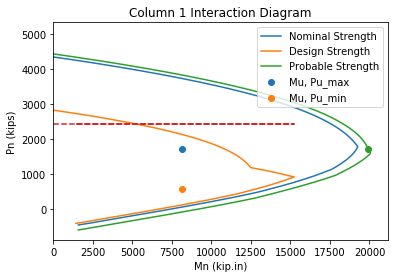

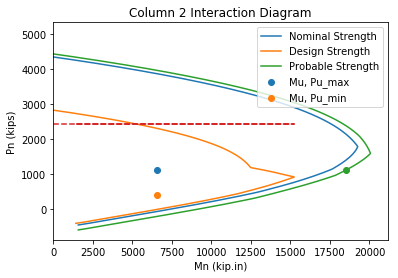

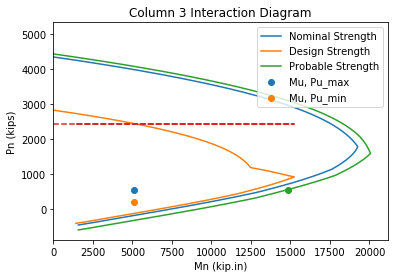

In [43]:
# columns design
#ccover = 1.5 # clear cover

bcols = [bcol,bcol,bcol] # widths of columns
dcols = [dcol,dcol,dcol] # depth of columns
dbar_l_col = [1.0,1.0,1.0] # diameter of longitudinal bars
nbar_col = 12 # number of longitudinal bars distributed uniformly
dbar_t_col = 0.5 # diameter of transverse bars
hoop_s_final = [4,4,4] # spacing of hoops along the entire column (will be checked against minima)
nlegs_col = 4 # number of transverse bars legs

Hcols = [Hcol1,Hcol,Hcol]
hoop_s_end = np.empty(len(col_groups)) # transverse reinforcement spacing at column ends

print("Get the effective length factor k using section 9.1 of this document to evaluate column slenderness. \n")
print("-------------------------------------------------------------------------------------------------------")
k_vec = [1.77,2.55,2.55]
# effective length factor, calculated based on the chart in ACI 318-14 R6.2.5
# note: these k factors should be the factors for the "edge" columns, which are more critical than the interior columns 
# because they are only bounded by one beam

for i in range(0,len(col_groups)):    
    hoop_s_end[i] = col_design(col_groups[i],beam_groups[i],Hcols[i],hbeams[i],bcols[i],dcols[i],ccover,\
                               dbar_l_col[i],dbar_t_col,nlegs_col,Pu_max[i],Pu_min[i],M_prob_neg[i],M_prob_pos[i],\
                               hoop_s_final[i],k_vec[i],mag_Mu_col[i])



### 9.7. Summary of Member Designs

In [44]:
# Summarize all member designs
print('DESIGN OF BEAMS:')
for i in range(0,len(beam_groups)):
    print('- BEAM',i+1,'GROUP:')
    print('Dimensions:',bbeams[i],'inches by',hbeams[i],'inches')
    print('Longitudinal rft:',nbars_neg[i],'bars of',dbars_neg[i],'inch diameter bars at the top')
    print('Longitudinal rft:',nbars_pos[i],'bars of',dbars_pos[i],'inch diameter bars at the bottom')
    print('Transverse rft:',nlegs,'legs of',dbar_t,'inch diameter bars at',s_beam_final[i],'inch spacing, with reduced',\
          s_max_end[i],'inch spacing at beam ends \n')
print('----------------------------------------------------------------------------------------------------------------') 
print('DESIGN OF COLUMNS:')
for i in range(0,len(col_groups)):
    print('- COLUMN',i+1,'GROUP:')
    print('Dimensions:',bcols[i],'inches by',dcols[i],'inches')
    print('Longitudinal rft:',nbar_col,'bars of',dbar_l_col[i],'inch diameter bars distributed uniformly')
    print('Transverse rft:',nlegs_col,'legs of',dbar_t_col,'inch diameter bars at',hoop_s_final[i],\
          'inch spacing, with reduced',hoop_s_end[i],'inch spacing at column ends \n')

DESIGN OF BEAMS:
- BEAM 1 GROUP:
Dimensions: 20 inches by 30 inches
Longitudinal rft: 4 bars of 1.128 inch diameter bars at the top
Longitudinal rft: 4 bars of 1.0 inch diameter bars at the bottom
Transverse rft: 4 legs of 0.5 inch diameter bars at 6.0 inch spacing, with reduced 6.0 inch spacing at beam ends 

- BEAM 2 GROUP:
Dimensions: 20 inches by 30 inches
Longitudinal rft: 4 bars of 1.128 inch diameter bars at the top
Longitudinal rft: 4 bars of 1.0 inch diameter bars at the bottom
Transverse rft: 4 legs of 0.5 inch diameter bars at 6.0 inch spacing, with reduced 6.0 inch spacing at beam ends 

- BEAM 3 GROUP:
Dimensions: 20 inches by 30 inches
Longitudinal rft: 4 bars of 1.0 inch diameter bars at the top
Longitudinal rft: 3 bars of 1.0 inch diameter bars at the bottom
Transverse rft: 4 legs of 0.5 inch diameter bars at 6.0 inch spacing, with reduced 6.0 inch spacing at beam ends 

----------------------------------------------------------------------------------------------------